# Introduction to rio-tiler

The goal of this notebook is to give a quick introduction of the main rio-tiler features.

# Requirements

To be able to run this notebook you'll need the following requirements:
- rio-tiler~=7.0
- matplotlib

In [1]:
# !pip install rio-tiler matplotlib

In [1]:
import morecantile
from matplotlib.pyplot import imshow, plot, subplots

from rio_tiler.io import Reader
from rio_tiler.models import ImageData

In [2]:
# For this DEMO we will use this file
src_path = "https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_2573-1085/swissalti3d_2019_2573-1085_0.5_2056_5728.tif"

## rio_tiler.io.COGReader

In `rio-tiler` 2.0 we introduced COGReader (renamed Reader in 4.0), which is a python class providing usefull methods to read and inspect any GDAL/rasterio raster dataset.

Docs: [https://cogeotiff.github.io/rio-tiler/readers/#cogreader](https://cogeotiff.github.io/rio-tiler/readers/#cogreader) 

In [3]:
?Reader

Init signature:
Reader(
    input: str,
    dataset: Union[rasterio.io.DatasetReader, rasterio.io.DatasetWriter, rasterio.io.MemoryFile, rasterio.vrt.WarpedVRT] = None,
    tms: morecantile.models.TileMatrixSet = <TileMatrixSet title='Google Maps Compatible for the World' id='WebMercatorQuad' crs='http://www.opengis.net/def/crs/EPSG/0/3857>,
    colormap: Dict = None,
    options: rio_tiler.reader.Options = NOTHING,
) -> None
Docstring:     
Rasterio Reader.

Attributes:
    input (str): dataset path.
    dataset (rasterio.io.DatasetReader or rasterio.io.DatasetWriter or rasterio.vrt.WarpedVRT, optional): Rasterio dataset.
    tms (morecantile.TileMatrixSet, optional): TileMatrixSet grid definition. Defaults to `WebMercatorQuad`.
    colormap (dict, optional): Overwrite internal colormap.
    options (dict, optional): Options to forward to low-level reader methods.

Examples:
    >>> with Reader(src_path) as src:
        src.tile(...)

    >>> # Set global options
        with Reader(s

### Info

Read GDAL/Rasterio dataset metadata

In [4]:
# As for Rasterio, using context manager is a good way to
# make sure the dataset are closed when we exit.
with Reader(src_path) as src:
    print("rasterio dataset:")
    print(src.dataset)
    print()
    print("metadata from rasterio:")
    print(src.dataset.meta)
    print()
    # Using rio-tiler Info() method
    info = src.info()
    print("rio-tiler dataset info:")
    print(src.info().json(exclude_none=True))

print(src.dataset.closed)

rasterio dataset:
<open DatasetReader name='https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_2573-1085/swissalti3d_2019_2573-1085_0.5_2056_5728.tif' mode='r'>

metadata from rasterio:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 2000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(2056), 'transform': Affine(0.5, 0.0, 2573000.0,
       0.0, -0.5, 1086000.0)}

rio-tiler dataset info:
{"bounds":[2573000.0,1085000.0,2574000.0,1086000.0],"crs":"http://www.opengis.net/def/crs/EPSG/0/2056","band_metadata":[["b1",{"STATISTICS_COVARIANCES":"10685.98787505646","STATISTICS_EXCLUDEDVALUES":"-9999","STATISTICS_MAXIMUM":"2015.0944824219","STATISTICS_MEAN":"1754.471184271","STATISTICS_MINIMUM":"1615.8128662109","STATISTICS_SKIPFACTORX":"1","STATISTICS_SKIPFACTORY":"1","STATISTICS_STDDEV":"103.37305197708"}]],"band_descriptions":[["b1",""]],"dtype":"float32","nodata_type":"Nodata","colorinterp":["gray"],"scales":[1.0],"offsets":[0.0],"driver":"GTiff","count"

### Statistics

Return basic data statistics

In [5]:
with Reader(src_path) as src:
    meta = src.statistics(max_size=256)

    assert isinstance(meta, dict)
    print(list(meta))
    print(meta["b1"].model_dump())

['b1']
{'min': 1615.81982421875, 'max': 2015.094482421875, 'mean': 1754.5912663564086, 'count': 65536.0, 'sum': 114988893.2319336, 'std': 103.58233071842892, 'median': 1721.393310546875, 'majority': 1957.414794921875, 'minority': 1615.81982421875, 'unique': 61645.0, 'histogram': [[10417, 15877, 9360, 6441, 5490, 4938, 4231, 3141, 3532, 2109], [1615.81982421875, 1655.747314453125, 1695.6748046875, 1735.6021728515625, 1775.5296630859375, 1815.4571533203125, 1855.3846435546875, 1895.3121337890625, 1935.239501953125, 1975.1669921875, 2015.094482421875]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 65536.0, 'percentile_2': 1626.7139892578125, 'percentile_98': 1987.7581787109375}


#### Plot Histogram values

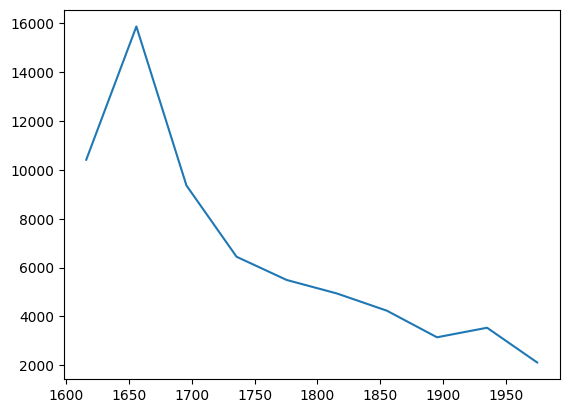

In [6]:
# Band 1
plot(meta["b1"].histogram[1][0:-1], meta["b1"].histogram[0])

### Preview

Read a low resolution version of the data (useful when working with COG, because this method will only fetch the overview layer it needs)

In [7]:
with Reader(src_path) as src:
    # By default `preview()` will return an array with its longest dimension lower or equal to 1024px
    data = src.preview()
    print(data.data.shape)
    assert isinstance(data, ImageData)

(1, 1024, 1024)


#### The ImageData class

To ease data manipulation, `rio-tiler` version 2.0 uses a new `ImageData` class that holds the arrays returned by rio-tiler/rasterio low level functions.

Docs: https://cogeotiff.github.io/rio-tiler/models/#imagedata

In [8]:
print(f"width: {data.width}")
print(f"height: {data.height}")
print(f"bands: {data.count}")
print(f"crs: {data.crs}")
print(f"bounds: {data.bounds}")
print(f"metadata: {data.metadata}")
print(f"assets: {data.assets}")
print(f"dataset stats: {data.dataset_statistics}")  # If stored in the original dataset

print(type(data.data))
print(type(data.mask))

width: 1024
height: 1024
bands: 1
crs: EPSG:2056
bounds: BoundingBox(left=2573000.0, bottom=1085000.0, right=2574000.0, top=1086000.0)
metadata: {'AREA_OR_POINT': 'Area'}
assets: ['https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_2573-1085/swissalti3d_2019_2573-1085_0.5_2056_5728.tif']
dataset stats: [(1615.8128662109, 2015.0944824219)]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### Display the data

<class 'rio_tiler.models.ImageData'>
(1, 1024, 1024)
<class 'numpy.ma.MaskedArray'>
(1024, 1024, 1)


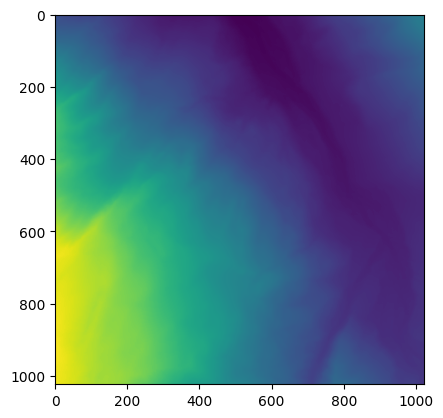

In [9]:
# Rasterio doesn't use the same axis order than visualization libraries (e.g matplotlib, PIL)
# in order to display the data we need to change the order (using rasterio.plot.array_to_image).
# the ImageData class wraps the rasterio function in the `data_as_image()` method.
print(type(data))
print(data.data.shape)

image = data.data_as_image()
# data_as_image() returns a numpy.ndarray
print(type(image))
print(image.shape)

imshow(image)

## Multi Spectral Data

For this demo we will use some High resolution RGB-Nir data hosted on [AWS](https://registry.opendata.aws/nj-imagery/).



In [10]:
src_path = "https://njogis-imagery.s3.amazonaws.com/2020/cog/I7D16.tif"

In [11]:
with Reader(src_path) as src:
    info = src.info()
    print("rio-tiler dataset info:")
    print(info.json(exclude_none=True))

rio-tiler dataset info:
{"bounds":[544999.99999999,645000.0,549999.99999999,650000.0],"crs":"http://www.opengis.net/def/crs/EPSG/0/6527","band_metadata":[["b1",{}],["b2",{}],["b3",{}],["b4",{}]],"band_descriptions":[["b1",""],["b2",""],["b3",""],["b4",""]],"dtype":"uint16","nodata_type":"None","colorinterp":["red","green","blue","undefined"],"scales":[1.0,1.0,1.0,1.0],"offsets":[0.0,0.0,0.0,0.0],"driver":"GTiff","count":4,"width":5000,"height":5000,"overviews":[2,4,8,16]}


['b1', 'b2', 'b3', 'b4']


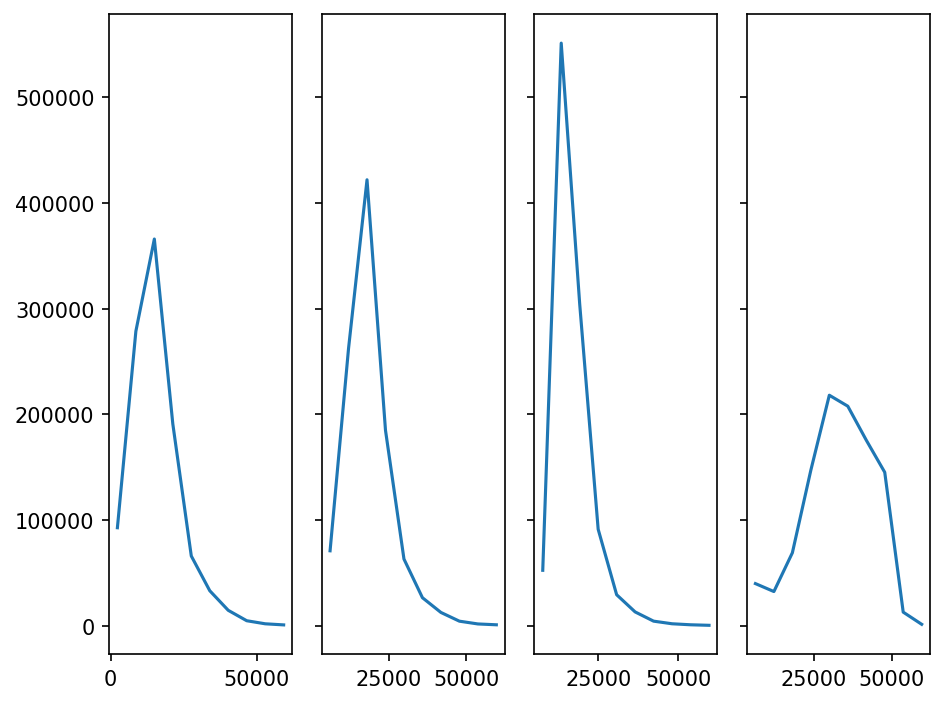

In [12]:
with Reader(src_path) as src:
    meta = src.statistics()

print(list(meta))

fig, axs = subplots(1, 4, sharey=True, tight_layout=True, dpi=150)
# Red (index 1)
axs[0].plot(meta["b1"].histogram[1][0:-1], meta["b1"].histogram[0])

# Green (index 2)
axs[1].plot(meta["b2"].histogram[1][0:-1], meta["b2"].histogram[0])

# Blue (index 3)
axs[2].plot(meta["b3"].histogram[1][0:-1], meta["b3"].histogram[0])

# Nir (index 3)
axs[3].plot(meta["b4"].histogram[1][0:-1], meta["b4"].histogram[0])

#### Using Expression

`rio-tiler` reader methods accept `indexes` option to select the bands you want to read, but also `expression` to perform band math.

(1, 1024, 1024)
uint16


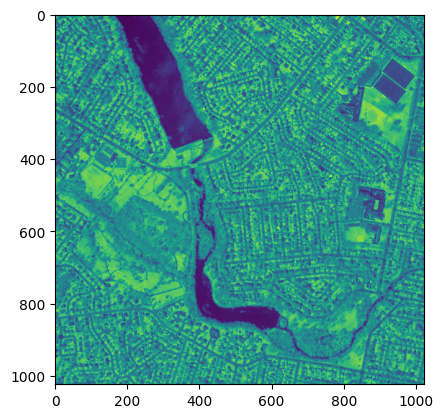

In [13]:
with Reader(src_path) as src:
    # Return only the third band
    nir_band = src.preview(indexes=4)
    print(nir_band.data.shape)
    print(nir_band.data.dtype)

imshow(nir_band.data_as_image())

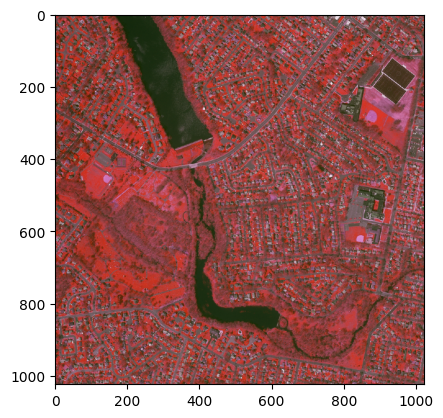

In [14]:
with Reader(src_path) as src:
    # Return only the third band
    nrg = src.preview(indexes=(4, 3, 1))

    # Data is in Uint16 so we need to rescale
    nrg.rescale(((nrg.data.min(), nrg.data.max()),))

imshow(nrg.data_as_image())

(1, 1024, 1024)
float64
NDVI range:  -0.2865547317109613 0.844091888413218


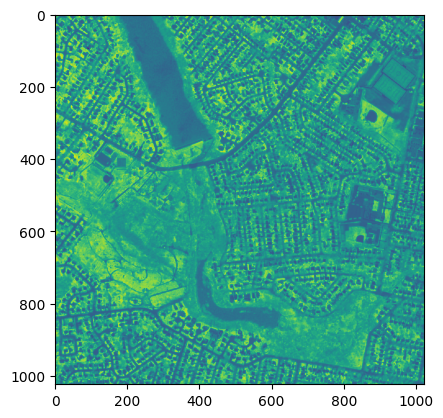

In [15]:
with Reader(src_path) as src:
    # Apply NDVI band math
    # (NIR - RED) / (NIR + RED)
    ndvi = src.preview(expression="(b4-b1)/(b4+b1)")
    print(ndvi.data.shape)
    print(ndvi.data.dtype)
    print("NDVI range: ", ndvi.data.min(), ndvi.data.max())

ndvi.rescale(in_range=((-1, 1),))
imshow(ndvi.data_as_image())

### Tile

Read data for a specific slippy map tile coordinates

In [17]:
with Reader(src_path) as src:
    print(f"Bounds in dataset CRS: {src.bounds}")
    print(f"Bounds WGS84: {src.get_geographic_bounds('epsg:4326')}")
    print(f"MinZoom (WebMercator): {src.minzoom}")
    print(f"MaxZoom (WebMercator): {src.maxzoom}")

Bounds in dataset CRS: (544999.99999999, 645000.0, 549999.99999999, 650000.0)
Bounds WGS84: (-74.3095632062702, 40.603994417539994, -74.29151245384847, 40.61775082944064)
MinZoom (WebMercator): 14
MaxZoom (WebMercator): 19


In [18]:
# rio-tiler defaults to the WebMercator Grids. The grid definition is provided by the morecantile module
# Docs: https://github.com/developmentseed/morecantile
tms = morecantile.tms.get("WebMercatorQuad")
print(repr(tms))

# Get the list of tiles for the COG minzoom
with Reader(src_path) as cog:
    tile_cover = list(
        tms.tiles(*cog.get_geographic_bounds("epsg:4326"), zooms=cog.minzoom)
    )

print(f"Nb of Z{cog.minzoom} Mercator tiles: {len(tile_cover)}")
print(tile_cover)

<TileMatrixSet title='Google Maps Compatible for the World' id='WebMercatorQuad' crs='http://www.opengis.net/def/crs/EPSG/0/3857>
Nb of Z14 Mercator tiles: 2
[Tile(x=4810, y=6165, z=14), Tile(x=4810, y=6166, z=14)]


In [19]:
with Reader(src_path) as src:
    img_1 = src.tile(*tile_cover[0])
    img_1.rescale(((0, 40000),))
    print(img_1.data.shape)

    img_2 = src.tile(*tile_cover[1])
    img_2.rescale(((0, 40000),))

    print(img_2.data.shape)

(4, 256, 256)
(4, 256, 256)


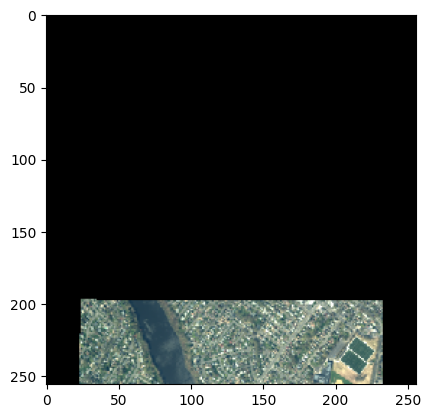

In [20]:
# Show the first 3 bands (RGB)
imshow(img_1.data_as_image()[:, :, 0:3])

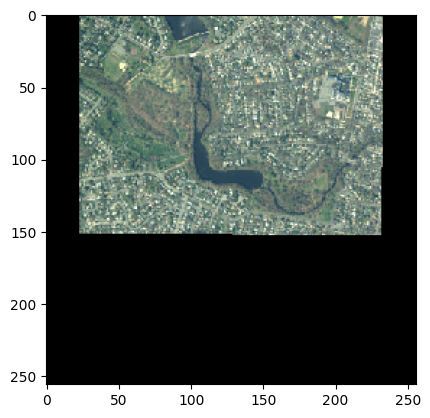

In [21]:
imshow(img_2.data_as_image()[:, :, 0:3])

(1, 256, 256)


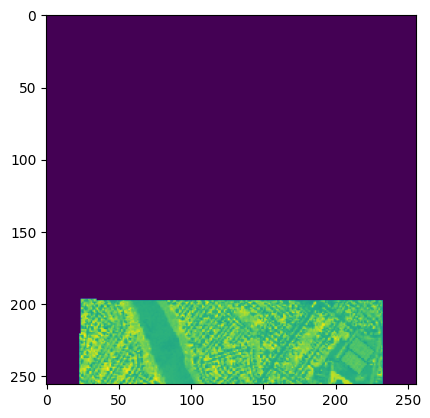

In [22]:
with Reader(src_path) as src:
    ndvi = src.tile(*tile_cover[0], expression="(b4-b1)/(b4+b1)")
    print(ndvi.data.shape)

ndvi.rescale(in_range=((-1, 1),))
imshow(ndvi.data[0])

### Part 

Read data for a given bounding box

In [23]:
with Reader(src_path) as src:
    # By default `part()` will read the highest resolution. We can limit this by using the `max_size` option.
    img = src.part(
        (-74.30680274963379, 40.60748547709819, -74.29478645324707, 40.61567903099978),
        max_size=1024,
    )
    print("data shape: ", img.data.shape)
    print("bounds: ", img.bounds)
    print("CRS: ", img.crs)

data shape:  (4, 699, 1024)
bounds:  BoundingBox(left=-74.30680274963379, bottom=40.60748547709819, right=-74.29478645324707, top=40.61567903099978)
CRS:  EPSG:4326


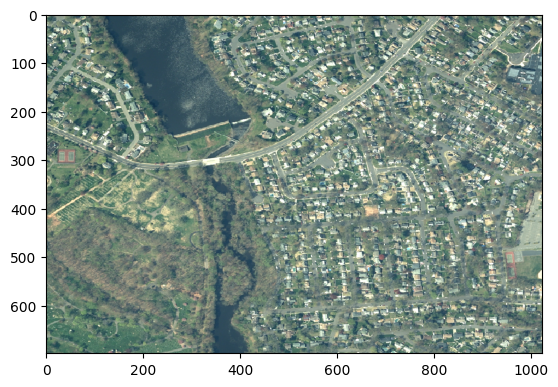

In [24]:
img.rescale(((0, 40000),))

imshow(img.data_as_image()[:, :, 0:3])

### Point

Read the pixel value for a specific lon/lat coordinate

In [25]:
with Reader(src_path) as src:
    pt = src.point(-74.30680274963379, 40.60748547709819)

    print("RGB-Nir values:")
    print([(b, pt.data[ii]) for ii, b in enumerate(pt.band_names)])

    print("NDVI values:")
    ndvi = pt.apply_expression("(b4-b1)/(b4+b1)")
    print([(b, ndvi.data[ii]) for ii, b in enumerate(ndvi.band_names)])

RGB-Nir values:
[('b1', np.uint16(11002)), ('b2', np.uint16(15954)), ('b3', np.uint16(14478)), ('b4', np.uint16(32050))]
NDVI values:
[('(b4-b1)/(b4+b1)', np.float64(0.48889714763541764))]


### Feature/GeoJSON

Read value for a geojson feature defined area

In [26]:
feat = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [-74.30384159088135, 40.614245638811646],
                [-74.30680274963379, 40.61121586776988],
                [-74.30590152740477, 40.608967884350946],
                [-74.30272579193115, 40.60748547709819],
                [-74.29875612258911, 40.60786015456402],
                [-74.2960524559021, 40.61012446497514],
                [-74.29478645324707, 40.61390357476733],
                [-74.29882049560547, 40.61515780103489],
                [-74.30294036865233, 40.61567903099978],
                [-74.3035626411438, 40.61502749290829],
                [-74.30384159088135, 40.614245638811646],
            ]
        ],
    },
}

In [27]:
with Reader(src_path) as src:
    # we use the feature to define the bounds and the mask
    # but we use `dst_crs` options to keep the projection from the input dataset
    # By default `feature()` will read the highest resolution. We can limit this by using the `max_size` option.
    img = src.feature(feat, dst_crs=src.crs, max_size=1024)
    print("data shape: ", img.data.shape)
    print("bounds: ", img.bounds)
    print("CRS: ", img.crs)

data shape:  (4, 917, 1024)
bounds:  BoundingBox(left=np.float64(545757.1269694079), bottom=np.float64(646262.094740576), right=np.float64(549099.8472835454), top=np.float64(649254.4633358669))
CRS:  EPSG:6527


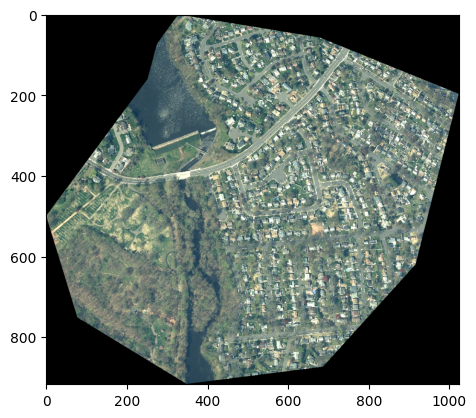

In [28]:
img.rescale(((0, 40000),))
imshow(img.data_as_image()[:, :, 0:3])